In [16]:
import os
import wave
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, filtfilt, lfilter
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Audio
from scipy.signal import spectrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import optuna

In [2]:
file_path = "C:/Users/User/OneDrive/Documents/Tugas_Kefas/Semester 5/Data Mining II/TM 6/set_b"
file_list = os.listdir(file_path)

In [3]:
datake = 1 #index file
file = os.listdir(file_path)[datake]#mengambil file
wav_file = wave.open(os.path.join(file_path, file), 'rb')#membuka file wav

num_channels = wav_file.getnchannels()#mendapatkan jumlah channel
sample_width = wav_file.getsampwidth()# mendapatkan sample width (bytes per sample)
frame_rate = wav_file.getframerate()  #Sample rate (samples per second)
num_frames = wav_file.getnframes()#jumlah dari  frames
duration = num_frames / float(frame_rate)  #dalam seconds
#menampilkan informasi
print(f"Channels: {num_channels}")
print(f"Sample Width: {sample_width} bytes")
print(f"Frame Rate: {frame_rate} Hz")
print(f"Number of Frames: {num_frames}")
print(f"Duration: {duration:.2f} seconds")

Channels: 1
Sample Width: 2 bytes
Frame Rate: 4000 Hz
Number of Frames: 87107
Duration: 21.78 seconds


Audio Array: [ -73 -226 -151 ...  121  112  141]
Array Shape: (87107,)


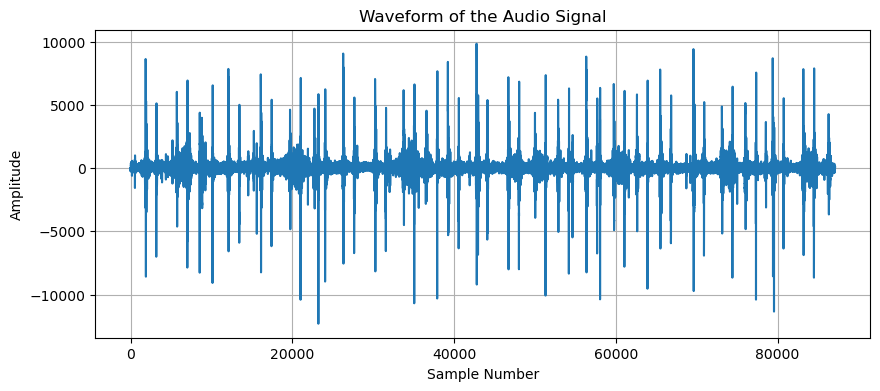

In [4]:
frames = wav_file.readframes(num_frames)
wav_file.close()

audio_data = np.frombuffer(frames, dtype=np.int16)

if num_channels > 1:
    audio_data = np.reshape(audio_data, (-1, num_channels))

print("Audio Array:", audio_data)
print("Array Shape:", audio_data.shape)

plt.figure(figsize=(10, 4))
if num_channels > 1:
    plt.plot(audio_data[:, 0])
else:
    plt.plot(audio_data)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [5]:
audio_to_play = audio_data[:, 0] if num_channels > 1 else audio_data

Audio(audio_to_play, rate=frame_rate)

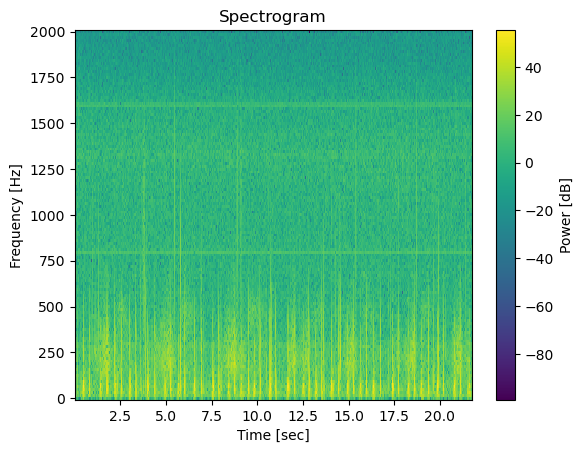

In [6]:
f, t, Sxx = spectrogram(audio_data[:,0] if num_channels > 1 else audio_data, frame_rate)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Power [dB]')
plt.show()

In [7]:
def load_audio_from_folder(folder_path):
    audio_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'): 
            full_path = os.path.join(folder_path, filename)
            try:
                signal, sr = librosa.load(full_path, sr=None)  # sr=None untuk mempertahankan frekuensi asli
                duration = len(signal) / sr
                audio_data.append({
                    'filename': full_path,
                    'signal': signal,
                    'sampling_rate': sr,
                    'duration': duration
                })
            except Exception as e:
                print(f"Error reading {full_path}: {e}")

    return audio_data

folder_path = "C:/Users/User/OneDrive/Documents/Tugas_Kefas/Semester 5/Data Mining II/TM 6/set_b"
audio_data = load_audio_from_folder(folder_path)
df = pd.DataFrame(audio_data)
df.head()

,filename,signal,sampling_rate,duration
0,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...,"[-0.006225586, -0.0035705566, 0.002746582, -0....",4000,10.59625
1,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...,"[-0.0022277832, -0.0068969727, -0.0046081543, ...",4000,21.77675
2,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...,"[0.013153076, 0.009094238, 0.012359619, 0.0133...",4000,2.66175
3,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...,"[-0.016143799, -0.013641357, -0.012664795, -0....",4000,7.22475
4,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...,"[-0.067352295, -0.056488037, -0.033721924, -0....",4000,8.42900


In [8]:
def normalize_audio(signal):
    """Normalizes the audio signal to the range [-1, 1]."""
    return signal / np.max(np.abs(signal))

def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    """Applies a band-pass filter to the audio signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def clip_or_pad(signal, target_samples):
    """Clips or pads the audio signal to the target length."""
    if len(signal) < target_samples:
        signal = np.pad(signal, (0, target_samples - len(signal)), 'constant')
    else:
        signal = signal[:target_samples]
    return signal  # Return the processed signal

def preprocess(row, target_duration):
    """Processes a single row of the DataFrame."""
    signal = row['signal']
    sr = row['sampling_rate']
    target_samples = int(target_duration * sr)
    
    normalized_signal = normalize_audio(signal)
    
    processed_signal = clip_or_pad(normalized_signal, target_samples)
    
    # Adjust the band-pass filter frequencies according to the characteristics of your data
    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1000, fs=sr)
    
    return filtered_signal

# Define target duration for padding/clipping
target_duration = 6  # in seconds
df['processed_signal'] = df.apply(lambda row: preprocess(row, target_duration), axis=1)

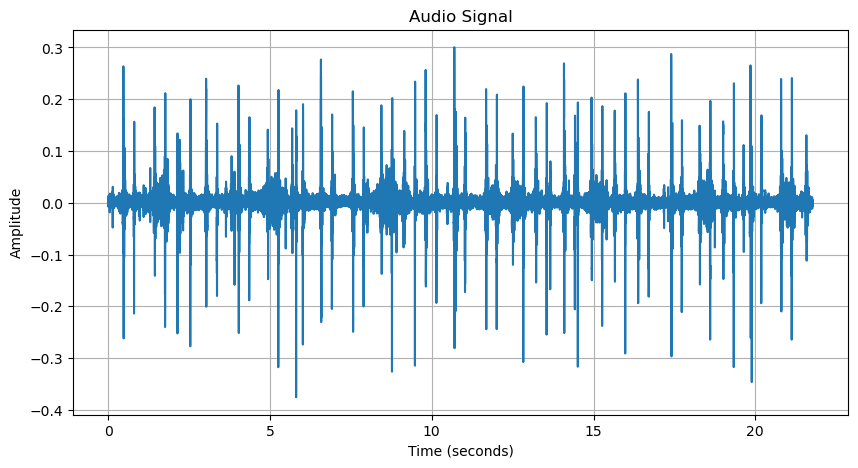

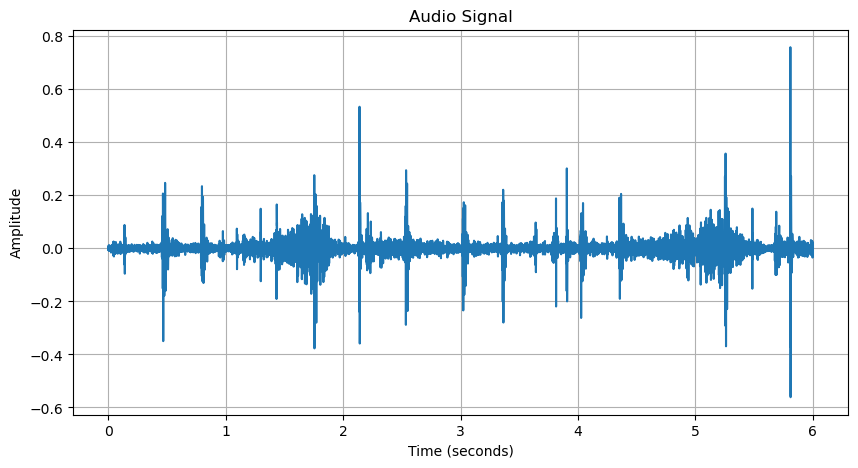

In [9]:
def plot_signal(signal, fs):
    """Plot the audio signal."""
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal)
    plt.title('Audio Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

fs = 4000  # Sampling rate
plot_signal(df['signal'][1], fs)
plot_signal(df['processed_signal'][1], fs)

In [10]:
def extract_features(signal, sr):
    # Menghitung rata-rata interval detak
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung HRV (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT dan puncak frekuensi
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi
    energy = np.sum(signal**2)

    # Menghitung MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Zero-crossing rate
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # RMS Energy
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    return {
        'mean_interval': mean_interval,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'peak_freq': peak_freq,
        'energy': energy,
        'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }
def extract_features(signal, sr):
    # Menghitung rata-rata interval detak
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung HRV (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT dan puncak frekuensi
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi
    energy = np.sum(signal**2)

    # Menghitung MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Zero-crossing rate
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # RMS Energy
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    return {
        'mean_interval': mean_interval,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'peak_freq': peak_freq,
        'energy': energy,
        'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }


def process_feature_extract(df):
    all_features = []

    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']
        
        features = extract_features(signal, sr)
        features['filename'] = row['filename']
        
        all_features.append(features)

    return pd.DataFrame(all_features)

features_df = process_feature_extract(df)

features_df.head()

def process_feature_extract(df):
    all_features = []

    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']
        
        features = extract_features(signal, sr)
        features['filename'] = row['filename']
        
        all_features.append(features)

    return pd.DataFrame(all_features)

features_df = process_feature_extract(df)

features_df.head()

,mean_interval,sdnn,rmssd,peak_freq,energy,mfcc_mean,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,chroma_mean,rms_mean,filename
0,0.000504,0.000628,0.000938,774.666667,60.914845,"[-273.402175097708, 169.34461920311807, -104.2...",0.215041,489.880435,271.148542,"[0.6262953095938942, 0.5553285557519008, 0.519...",0.032467,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...
1,0.000501,0.000757,0.001115,178.333333,35.787597,"[-289.0858593152694, 221.37776341351798, -71.9...",0.136386,319.003493,230.653877,"[0.6884532725194951, 0.6710218608132157, 0.695...",0.035905,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...
2,0.000499,0.000970,0.001410,101.500000,30.709736,"[-478.120618830632, 104.20759914359441, -37.45...",0.062874,210.725933,141.560199,"[0.3270570512247524, 0.34389912732115635, 0.36...",0.023596,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...
3,0.000497,0.000745,0.001104,177.333333,226.937911,"[-193.00065203937513, 235.7933495348705, -90.2...",0.134672,351.648289,235.944417,"[0.6658443325535252, 0.713647591060606, 0.7024...",0.088787,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...
4,0.000506,0.000906,0.001318,105.333333,69.965224,"[-279.51134394449576, 228.87387951523957, -62....",0.111048,260.531396,221.078821,"[0.442348136996964, 0.49530369329722207, 0.526...",0.053003,C:/Users/User/OneDrive/Documents/Tugas_Kefas/S...


In [11]:
mfcc_flattened = np.array(features_df['mfcc_mean'].tolist())
chroma_flattened = np.array(features_df['chroma_mean'].tolist())

X = np.hstack((
    features_df[['mean_interval', 'sdnn', 'rmssd', 'peak_freq', 'energy','zero_crossing_rate', 'spectral_centroid_mean',
       'spectral_bandwidth_mean','rms_mean']].values,
    mfcc_flattened,chroma_flattened
))

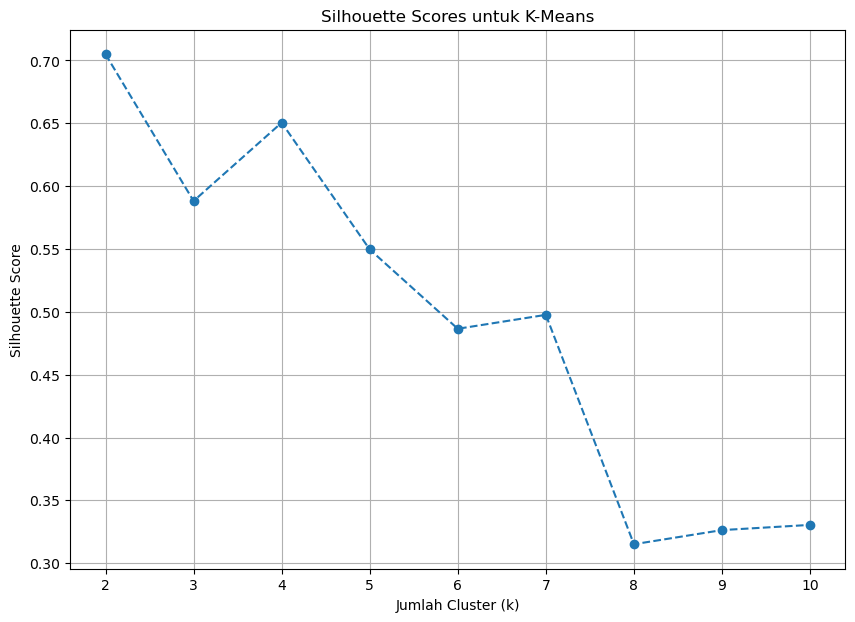

In [12]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

def calculate_silhouette_score_kmeans(max_clusters=10, X=None):
    silhouette_scores = []
    
    # Looping dari 2 cluster sampai max_clusters
    for i in range(2, max_clusters + 1):
        # Mengganti GaussianMixture dengan KMeans
        # Parameter n_components diganti menjadi n_clusters
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X)
        
        # Untuk KMeans, label bisa didapat dari atribut .labels_
        labels = kmeans.labels_
        
        # Menghitung silhouette score
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot Silhouette Score
    plt.figure(figsize=(10, 7))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
    plt.title('Silhouette Scores untuk K-Means')
    plt.xlabel('Jumlah Cluster (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Panggil fungsi dengan data X
calculate_silhouette_score_kmeans(max_clusters=10, X=X)

In [13]:
# Membuat data sampel 
# Ganti X dengan data Anda yang sebenarnya
X, y = make_blobs(n_samples=500, centers=4, cluster_std=1.0, random_state=42)

# 1. Definisikan parameter untuk KMeans
# Parameter utama adalah n_clusters, yang setara dengan n_components
params_kmeans = {'n_clusters': 4}

# 2. Inisialisasi model KMeans
# Tambahkan n_init='auto' untuk menghindari warning & random_state untuk hasil konsisten
kmeans = KMeans(**params_kmeans, random_state=42, n_init='auto')

# 3. Lakukan fitting dan prediksi cluster dalam satu langkah
cluster = kmeans.fit_predict(X)

# 4. Hitung Silhouette Score)
silhouette_avg = silhouette_score(X, cluster)
print(f"Silhouette Score untuk K-Means: {silhouette_avg}")


Silhouette Score untuk K-Means: 0.7911042588289479


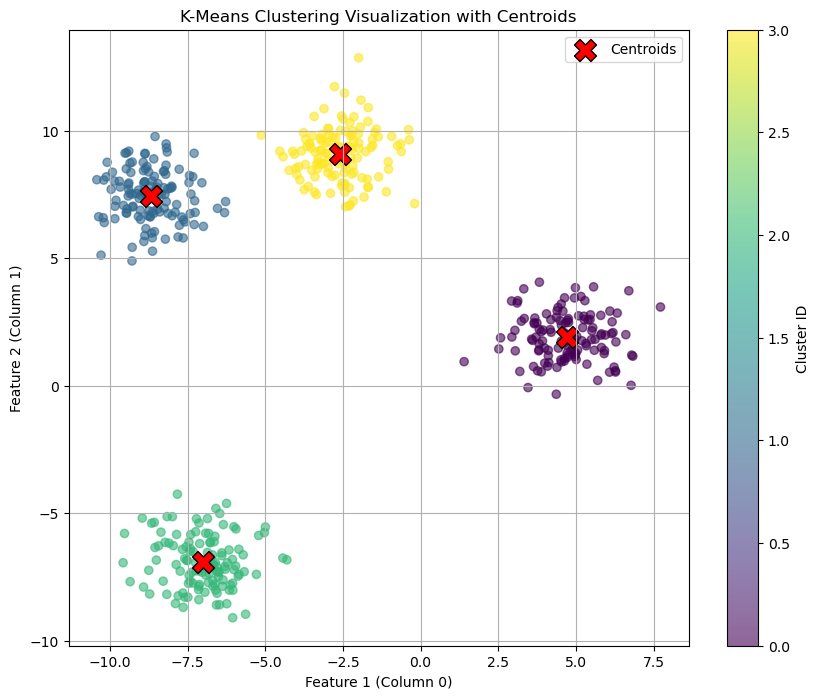

In [14]:
# Mengambil lokasi centroid dari model kmeans yang sudah dilatih
centroids = kmeans.cluster_centers_

#Membuat plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X[:,0], X[:,1], c=cluster, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.scatter(centroids[:, 0], centroids[:, 1], s=250, c='red', marker='X', 
            edgecolor='black', label='Centroids')

# Memberi judul dan label
plt.title('K-Means Clustering Visualization with Centroids')
plt.xlabel('Feature 1 (Column 0)') # Label diubah agar sesuai
plt.ylabel('Feature 2 (Column 1)') # Label diubah agar sesuai
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def objective(trial):
    # 1. Parameter yang ingin dituning untuk K-Means
    # n_components -> n_clusters
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    
    # Menambahkan parameter khas K-Means
    init_method = trial.suggest_categorical("init", ["k-means++", "random"])
    n_init_value = trial.suggest_int("n_init", 5, 30)
    
    # 2. Definisikan model K-Means
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init_value,
        random_state=42
    )
    
    # 3. Fit dan prediksi label dalam satu langkah (lebih efisien untuk KMeans)
    labels = kmeans.fit_predict(X)
    
    # 4. Evaluasi menggunakan Silhouette Score (langkah ini sama)
    # Menangani kasus jika hanya ada 1 cluster terbentuk (silhouette score tidak terdefinisi)
    try:
        score = silhouette_score(X, labels)
    except ValueError:
        score = -1 # Beri skor penalti jika gagal
    
    return score

# Buat studi Optuna untuk memaksimalkan score
study = optuna.create_study(direction="maximize")
# Jalankan optimasi (jumlah trials bisa disesuaikan)
study.optimize(objective, n_trials=50)

# Cetak hasil terbaik
print("Parameter terbaik:", study.best_params)
print("Skor Silhouette terbaik:", study.best_value)

[I 2025-09-21 23:23:44,214] A new study created in memory with name: no-name-ac026b58-5eaa-4d66-b797-a2ac3c319911
[I 2025-09-21 23:23:44,260] Trial 0 finished with value: 0.7911042588289479 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 16}. Best is trial 0 with value: 0.7911042588289479.
[I 2025-09-21 23:23:44,339] Trial 1 finished with value: 0.44148278488232606 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 28}. Best is trial 0 with value: 0.7911042588289479.
[I 2025-09-21 23:23:44,368] Trial 2 finished with value: 0.7613478432173022 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 10}. Best is trial 0 with value: 0.7911042588289479.
[I 2025-09-21 23:23:44,423] Trial 3 finished with value: 0.3495290469285122 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'n_init': 17}. Best is trial 0 with value: 0.7911042588289479.
[I 2025-09-21 23:23:44,449] Trial 4 finished with value: 0.7613478432173022 and parameters: {'n_clusters': 3

Parameter terbaik: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 16}
Skor Silhouette terbaik: 0.7911042588289479
